**FOOD RECOMMENDATION SYSTEM**

## Installing required libraries 

In [ ]:
!pip install -U sentence-transformers

     |████████████████████████████████| 78 kB 2.9 MB/s 
     |████████████████████████████████| 3.1 MB 28.3 MB/s 
     |████████████████████████████████| 3.3 MB 32.1 MB/s 
     |████████████████████████████████| 1.2 MB 52.2 MB/s 
     |████████████████████████████████| 59 kB 6.2 MB/s 
     |████████████████████████████████| 596 kB 57.6 MB/s 
     |████████████████████████████████| 895 kB 55.6 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=6c9a5d3fb24c0c3014d501b541fcd72686ac828168f83c22a8e0d223a69e2480
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Importing libraries 

In [ ]:
%matplotlib inline
import re
import csv
import gzip
import string
import numpy as np
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.cluster import Birch
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer
from scipy.spatial.distance import cosine
from wordcloud import WordCloud, STOPWORDS
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, ENGLISH_STOP_WORDS

## Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading datasets

In [ ]:
rec_df = pd.read_csv('/content/drive/My Drive/MLProject/recipes.csv')
rev_df = pd.read_csv('/content/drive/My Drive/MLProject/reviews.csv')

In [ ]:
rev_cols = ['ReviewId', 'RecipeId', 'AuthorId', 'AuthorName', 'Rating', 'Review']
rec_cols = ['RecipeId', 'Name', 'AuthorId', 'AuthorName']

# DATA PREPROCESING

## Removing irrelavent columns

In [ ]:
colrev = list(rev_df.columns)
colrev

['ReviewId',
 'RecipeId',
 'AuthorId',
 'AuthorName',
 'Rating',
 'Review',
 'DateSubmitted',
 'DateModified']

In [ ]:
colrec = list(rec_df.columns)
colrec

['RecipeId',
 'Name',
 'AuthorId',
 'AuthorName',
 'CookTime',
 'PrepTime',
 'TotalTime',
 'DatePublished',
 'Description',
 'Images',
 'RecipeCategory',
 'Keywords',
 'RecipeIngredientQuantities',
 'RecipeIngredientParts',
 'AggregatedRating',
 'ReviewCount',
 'Calories',
 'FatContent',
 'SaturatedFatContent',
 'CholesterolContent',
 'SodiumContent',
 'CarbohydrateContent',
 'FiberContent',
 'SugarContent',
 'ProteinContent',
 'RecipeServings',
 'RecipeYield',
 'RecipeInstructions']

In [ ]:
rev_fcols = list(set(colrev) - set(rev_cols))
rev_fcols

['DateSubmitted', 'DateModified']

In [ ]:
rec_fcols = list(set(colrec) - set(rec_cols))
rec_fcols

['FiberContent',
 'RecipeYield',
 'CookTime',
 'ReviewCount',
 'CholesterolContent',
 'FatContent',
 'RecipeInstructions',
 'SaturatedFatContent',
 'TotalTime',
 'PrepTime',
 'RecipeIngredientQuantities',
 'DatePublished',
 'RecipeCategory',
 'Calories',
 'Keywords',
 'AggregatedRating',
 'Images',
 'SugarContent',
 'RecipeServings',
 'RecipeIngredientParts',
 'CarbohydrateContent',
 'SodiumContent',
 'Description',
 'ProteinContent']

In [ ]:
rec_df.drop(rec_fcols, inplace=True, axis=1)
rec_df

RecipeId  ...      AuthorName
0             38  ...          Dancer
1             39  ...        elly9812
2             40  ...  Stephen Little
3             41  ...         Cyclopz
4             42  ...       Duckie067
...          ...  ...             ...
522512    541379  ...           rdsxc
522513    541380  ...    Denver cooks
522514    541381  ...     Jonathan F.
522515    541382  ...       CLUBFOODY
522516    541383  ...    Chef LauraMD

[522517 rows x 4 columns]

In [ ]:
rev_df.drop(rev_fcols, inplace=True, axis=1)
rev_df

ReviewId  ...                                             Review
0               2  ...       better than any you can get at a restaurant!
1               7  ...  I cut back on the mayo, and made up the differ...
2               9  ...  i think i did something wrong because i could ...
3              13  ...  easily the best i have ever had.  juicy flavor...
4              14  ...                                 An excellent dish.
...           ...  ...                                                ...
1401977   2090339  ...  I was disappointed. I couldn't wait to make th...
1401978   2090340  ...  Nothing to drain. And I don’t heat up the liqu...
1401979   2090341  ...  Good base recipe for someone to start with. I ...
1401980   2090345  ...  Thank you so much for this amazing recipe! I l...
1401981   2090347  ...  I can't say enough about this recipe.... the b...

[1401982 rows x 6 columns]

## Merging the two datasets

In [ ]:
fin_df = pd.merge(rev_df, rec_df, on='RecipeId', how='inner')
fin_df

ReviewId  RecipeId  ...  AuthorId_y   AuthorName_y
0               2       992  ...        1545  Nancy Van Ess
1             250       992  ...        1545  Nancy Van Ess
2          242612       992  ...        1545  Nancy Van Ess
3          463486       992  ...        1545  Nancy Van Ess
4          643932       992  ...        1545  Nancy Van Ess
...           ...       ...  ...         ...            ...
1401958   2090227    537537  ...  2001201872    Izy Hossack
1401959   2090286    534306  ...      296050          Gagoo
1401960   2090302    537541  ...  2001201872    Izy Hossack
1401961   2090320    413571  ...       58104       Rita1652
1401962   2090332    230339  ...      161745        TJW2725

[1401963 rows x 9 columns]

## Renaming the columns

In [ ]:
fin_df.rename(columns = {'AuthorName_x':'Reviewer', 'AuthorName_y':'Author', 'AuthorId_y':'AuthorId'}, inplace = True)

In [ ]:
fin_df.drop(['AuthorId_x'], axis=1, inplace=True)

In [ ]:
fin_df = fin_df[['ReviewId', 'RecipeId', 'Name', 'AuthorId', 'Author', 'Reviewer', 'Review', 'Rating']]

## Dropping null values

In [ ]:
fin_df.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Selecting foods with more no of reviews

In [ ]:
fin_df = fin_df.groupby('Name').filter(lambda x:len(x)>=700).reset_index(drop=True)

In [ ]:
df = fin_df.copy()

In [ ]:
count = df.groupby("Name", as_index=False).count()

In [ ]:
mean = df.groupby("Name", as_index=False).mean()

In [ ]:
dfMerged = pd.merge(df, count, how='right', on=['Name'])

In [ ]:
dfMerged

ReviewId_x  RecipeId_x  ... Review_y  Rating_y
0           72459       32204  ...     1228      1228
1           76654       32204  ...     1228      1228
2           78410       32204  ...     1228      1228
3          102045       32204  ...     1228      1228
4          109354       32204  ...     1228      1228
...           ...         ...  ...      ...       ...
34368     2078455       54257  ...     1325      1325
34369     2080404       54257  ...     1325      1325
34370     2087487       54257  ...     1325      1325
34371     2088983       54257  ...     1325      1325
34372     2089142       54257  ...     1325      1325

[34373 rows x 15 columns]

In [ ]:
df1 = df[['Review','Rating','Name']]

In [ ]:
df1 = df1.dropna()

In [ ]:
df1

Review  ...               Name
0      I used one more banana than called for because...  ...  Best Banana Bread
1      I have been searching for a good banana bread ...  ...  Best Banana Bread
2      I have tried many many banana bread recipes ov...  ...  Best Banana Bread
3             Yes, this really is the BEST BANANA BREAD!  ...  Best Banana Bread
4      Tried this recipe and the Grandchildren love i...  ...  Best Banana Bread
...                                                  ...  ...                ...
34368  This is a good, basic and easy recipe, that ma...  ...       Mexican Rice
34369  Great recipe and easy, too.  I made one change...  ...       Mexican Rice
34370  Really great easy rice.  Didn&#039;t add the s...  ...       Mexican Rice
34371  This recipe is a keeper! I had to add a touch ...  ...           Pancakes
34372  Wow! what a great pancake. I've tried many pan...  ...           Pancakes

[34373 rows x 3 columns]

In [ ]:
dfProductReview = df.groupby("Name", as_index=False).mean()

In [ ]:
dfProductReview.head(3)

Name  ...    Rating
0  &quot;Whatever Floats Your Boat&quot; Brownies!  ...  4.521987
1                              Banana Banana Bread  ...  4.438084
2                                       Beer Bread  ...  4.289350

[3 rows x 5 columns]

In [ ]:
ProductReviewSummary = df1.groupby("Name")["Review"].apply(str)

In [ ]:
p = ProductReviewSummary.to_frame()

In [ ]:
p

Review
Name                                                                                                 
&quot;Whatever Floats Your Boat&quot; Brownies!     21224    Oh my MY MY!!!THESE ARE GOOD!!!! Sooo...
Banana Banana Bread                                 8530    I made these in muffins tins.  This is...
Beer Bread                                          2201     Didn't turn out well...I could taste ...
Best Banana Bread                                   0        I used one more banana than called fo...
Best Ever Banana Cake With Cream Cheese Frosting    18955    Oh yes, this is a very, very good ban...
Beth's Melt in Your Mouth Barbecue Ribs (Oven)      28505    Why would anyone bother to go to Tony...
Bourbon Chicken                                     9386     My first thought from the aroma of th...
Creamy Burrito Casserole                            9445     This casserole is great! It was easy ...
Creamy Cajun Chicken Pasta                          11696    FANTABULOUS!!!!  This dish was sooooo...
Crock Pot Whole Chicken                             13187    Scrumptious! Spice mix gave a great c...
Crock-Pot Chicken With Black Beans &amp; Cream ...  26182    This was wonderful, and the best part...
Delicious Chicken Pot Pie                           2242    This was excellent.I added mushrooms,b...
Fannie Farmer's Classic Baked Macaroni &amp; Ch...  30637    this is how my family makes it when n...
Ice Cubes                                           33139                                Ha Ha!! G...
Japanese Mum's Chicken                              20314    This was really easy to make, but we ...
Jo Mama's World Famous Spaghetti                    2981    This is by far, the best Spaghetti Sau...
Kittencal's Italian Melt-In-Your-Mouth Meatballs    23492    These were perfect to go with your sa...
Kittencal's Moist Cheddar-Garlic Oven Fried Chi...  24515    Tried this for Super Bowl Sunday, alo...
Mexican Rice                                        9387     Hands down, this is the best rice dis...
My Family's Favorite Sloppy Joes (Pizza Joes)       18222    Delicious, teenage son really enjoyed...
Oatmeal Raisin Cookies                              2177     Chewy and delicious, with just the ri...
Oven-Fried Chicken Chimichangas                     7726    This was quick and tasty, but I found ...
Pancakes                                            5036     Really really good, sweet pancakes. D...
Panera's Cream Cheese Potato Soup                   32233    This is a very nice soup. I halfed th...
Scalloped Potatoes                                  11682    Very easy to make and very flavorful....
Simply Sour Cream Chicken Enchiladas                31453    Hi,I just made this recipe yesterday ...
Soft Snickerdoodle Cookies                          27770    These are the best snickerdoodles I h...
Southern Buttermilk Biscuits                        4254    Delicious, light and tender biscuits.....
The Best Easy Beef and Broccoli Stir-Fry            29220    Excellent,simple recipe.  I added a f...
To Die for Crock Pot Roast                          6112    Being a single guy, this is right up m...
Yes, Virginia There is a Great Meatloaf             16892    My husband wanted a meatloaf like his...

In [ ]:
p.reset_index(inplace = True)

In [ ]:
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","i've": "i have","i'd": "i would", "i'd've": "i would have","i'll": "i will",
                     "i'll've": "i will have","i'm": "i am","i've": "i have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

fin_df['Review']=fin_df['Review'].apply(lambda x:expand_contractions(x))

In [ ]:
fin_df['cleaned']=fin_df['Review'].apply(lambda x: x.lower())

In [ ]:
fin_df['cleaned']=fin_df['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))

In [ ]:
fin_df['cleaned']=fin_df['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [ ]:
fin_df['cleaned']=fin_df['cleaned'].apply(lambda x: re.sub(' +',' ',x))

In [ ]:
fin_df['lemmatized'] = fin_df['cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
fin_df['lemmatized'] = fin_df['lemmatized'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word, pos="n") for word in x.split()]))

In [ ]:
fin_df['lemmatized'] = fin_df['lemmatized'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word, pos="v") for word in x.split()]))

In [ ]:
fin_df['lemmatized'] = fin_df['lemmatized'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word, pos="a") for word in x.split()]))

In [ ]:
df_grouped2=fin_df[['Name','lemmatized']].groupby(by='Name').agg(lambda x:' '.join(x))
df_grouped2.head()

lemmatized
Name                                                                                               
&quot;Whatever Floats Your Boat&quot; Brownies!   oh mythese good soooo chocolatey chewy tin foi...
Banana Banana Bread                               make muffin tin hand incredible banana breadmu...
Beer Bread                                        didnt turn welli could taste bake powder bad c...
Best Banana Bread                                 use one banana call use result bread yummy tho...
Best Ever Banana Cake With Cream Cheese Frosting  oh yes good banana cake easy put together wond...

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(analyzer='word')
data=cv.fit_transform(df_grouped2['lemmatized'])
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index=df_grouped2.index
df_dtm.head(3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


aa  aaa  ...  œsince  œtop
Name                                                      ...              
&quot;Whatever Floats Your Boat&quot; Brownies!   0    0  ...       0     0
Banana Banana Bread                               0    0  ...       0     0
Beer Bread                                        0    0  ...       0     0

[3 rows x 22736 columns]

## EDA

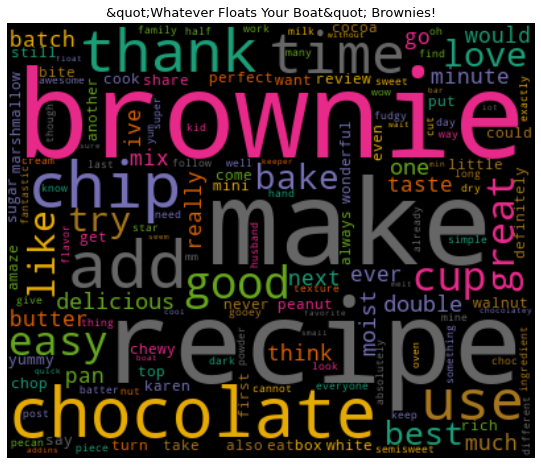

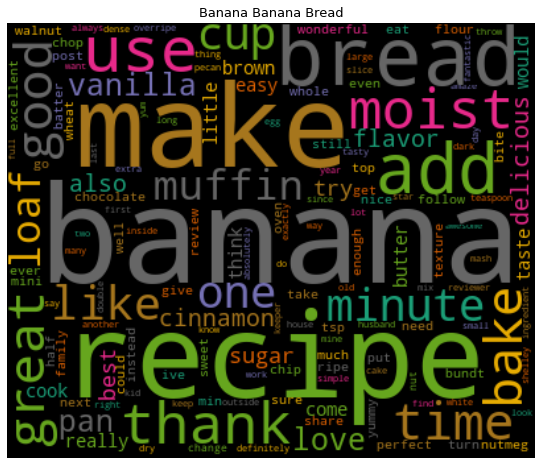

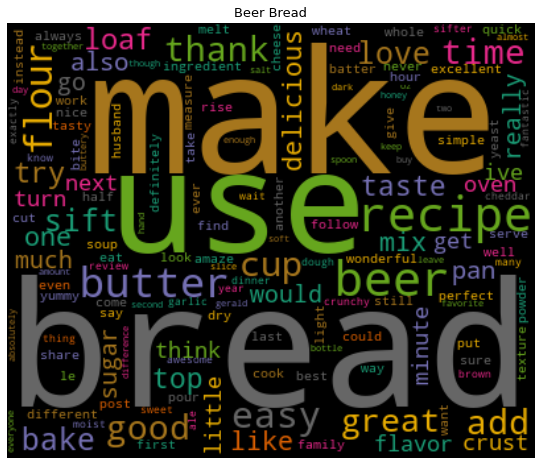

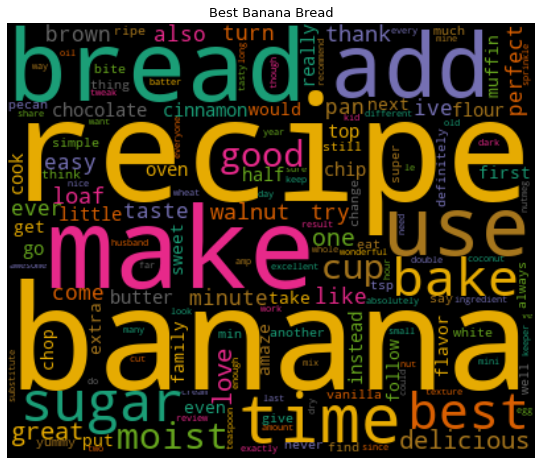

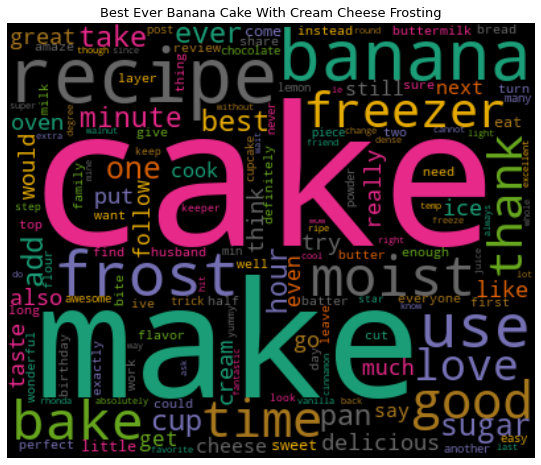

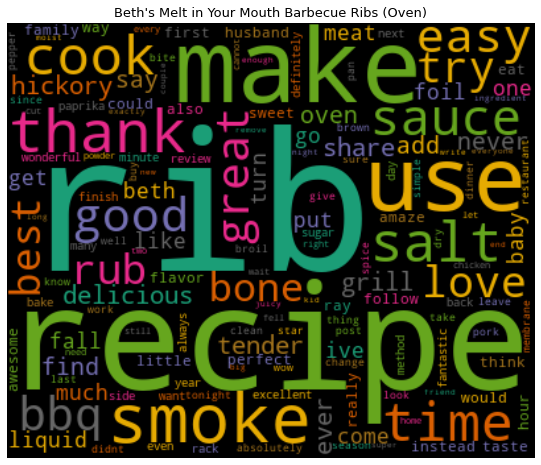

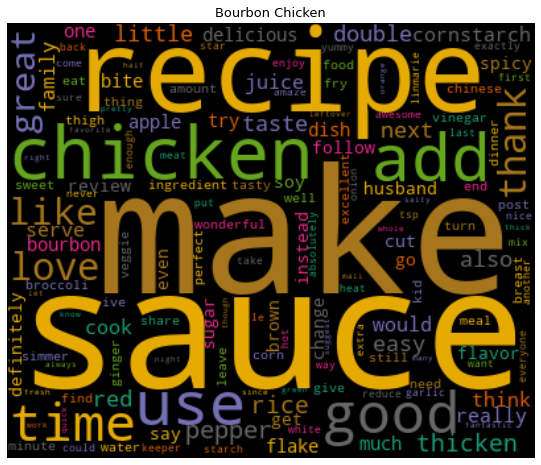

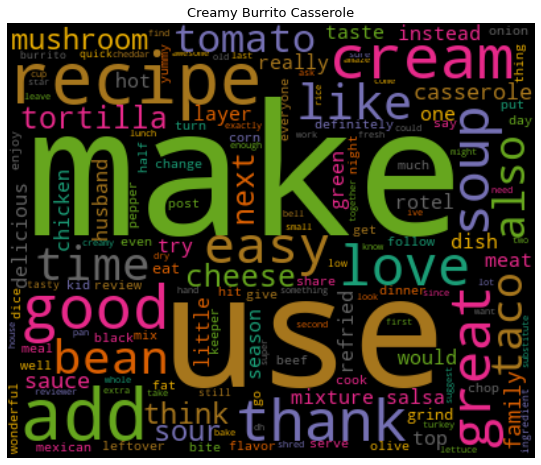

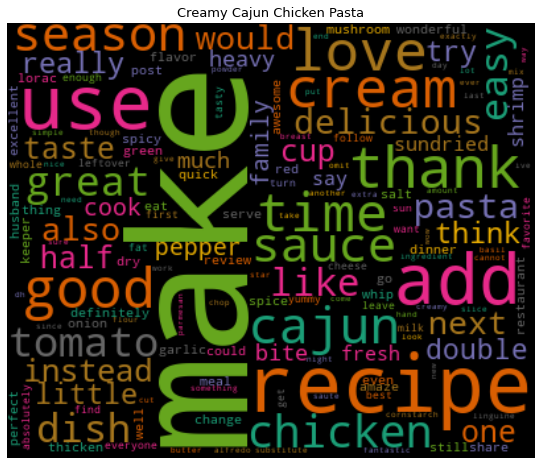

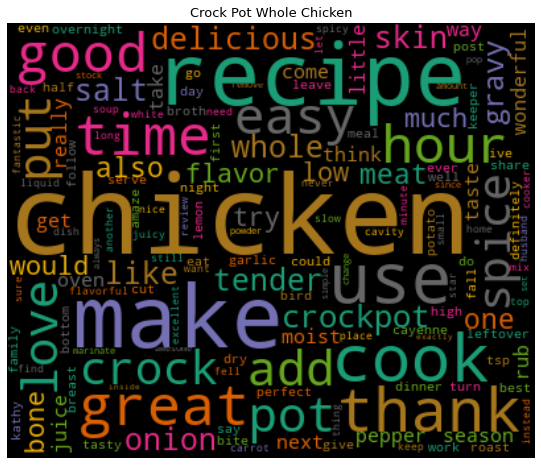

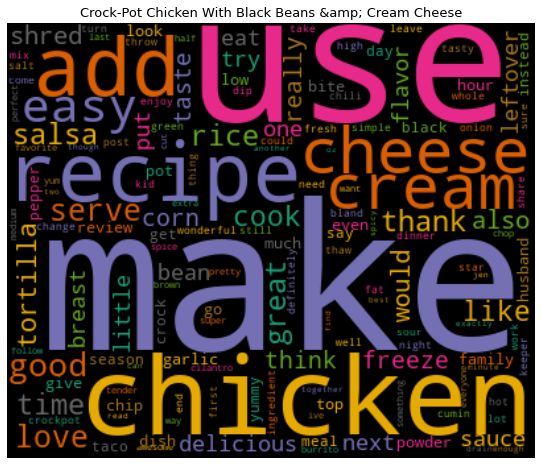

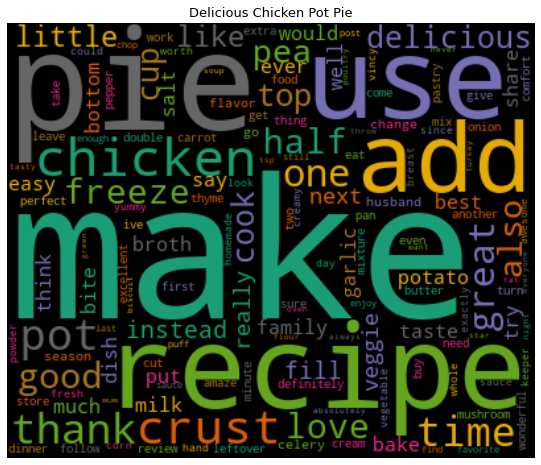

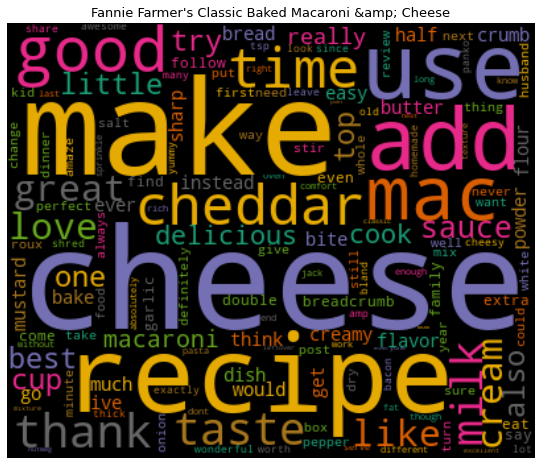

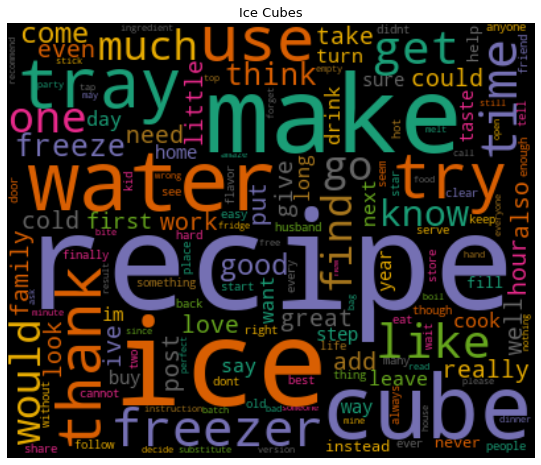

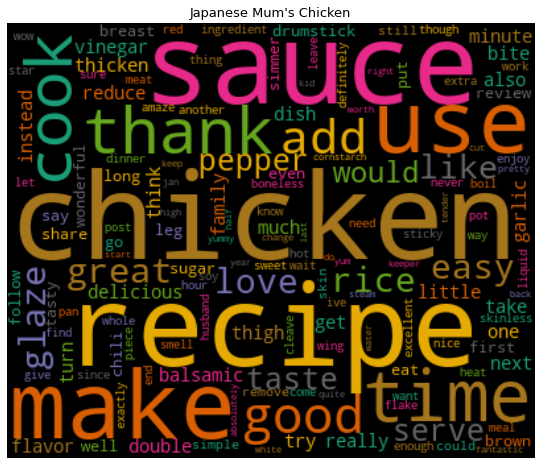

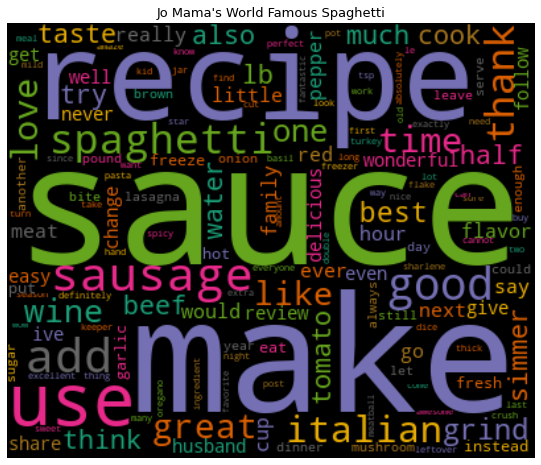

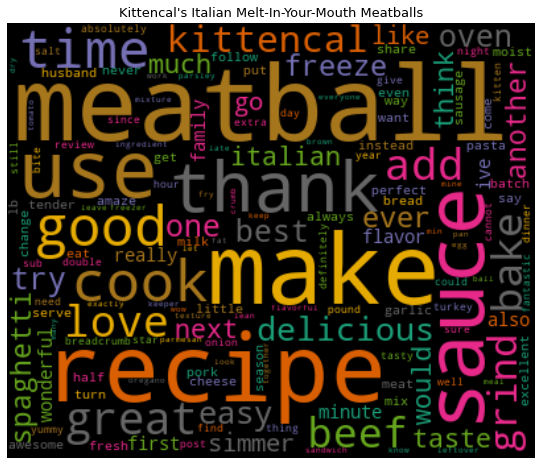

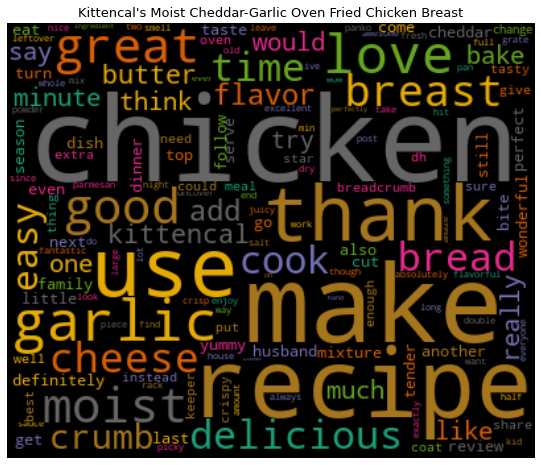

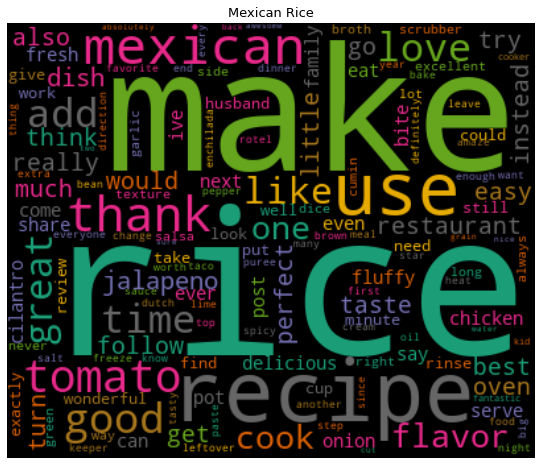

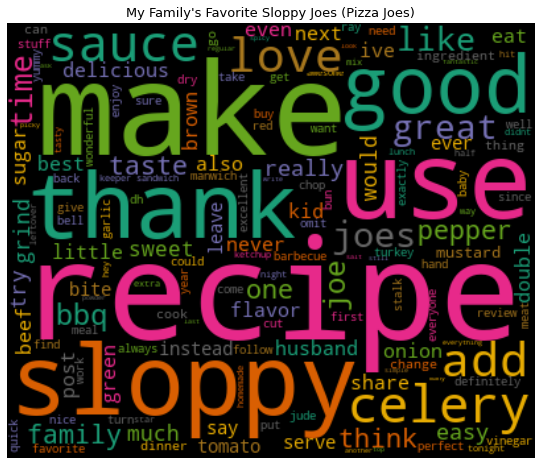

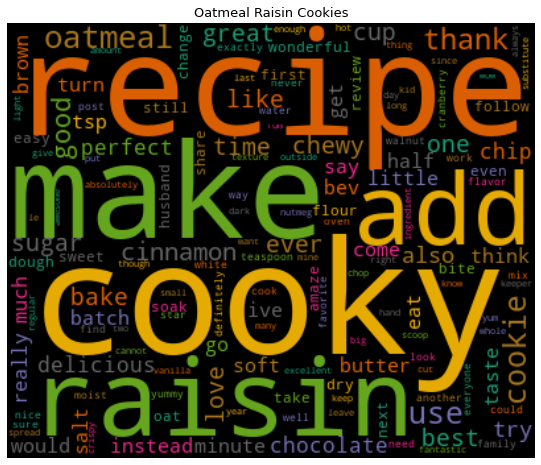

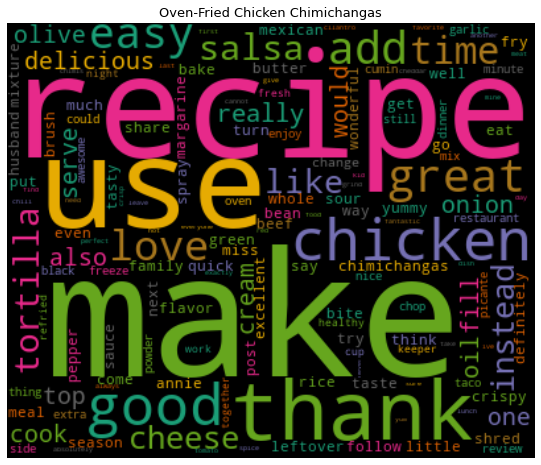

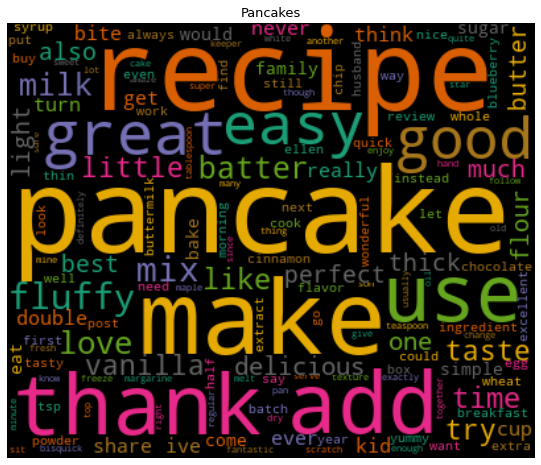

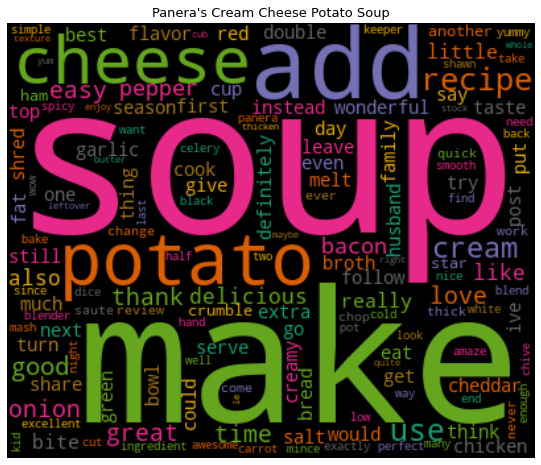

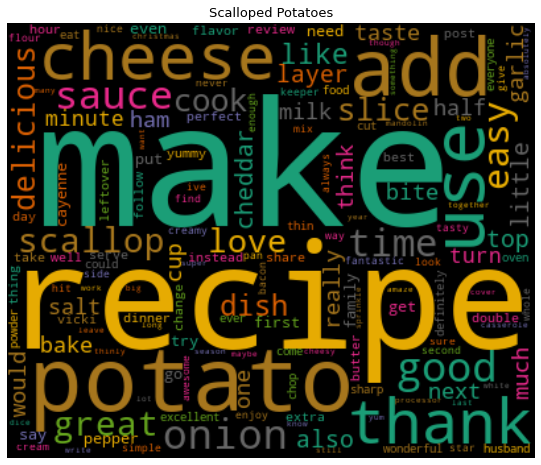

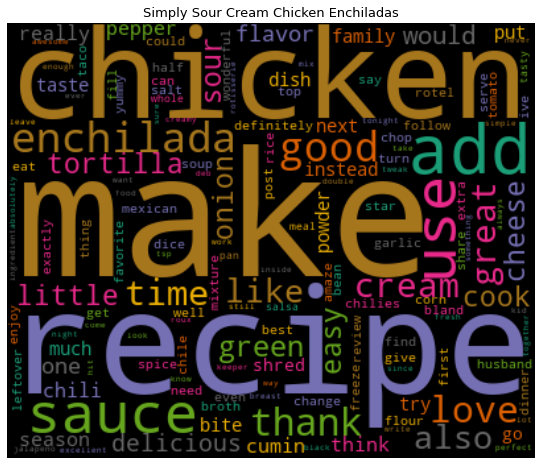

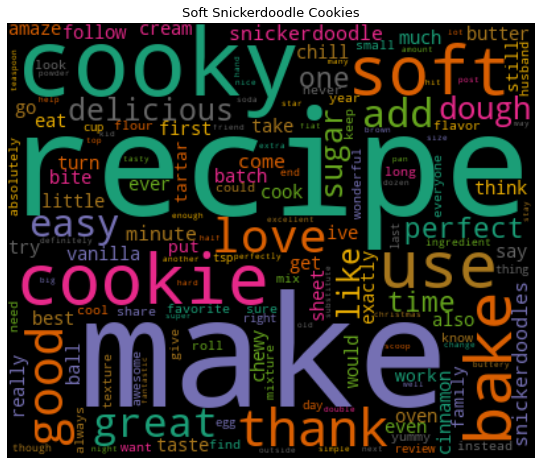

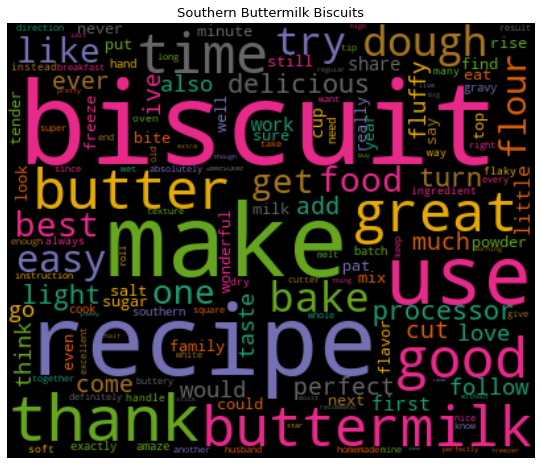

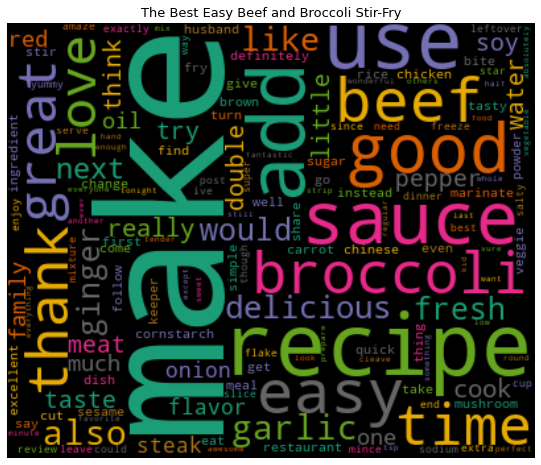

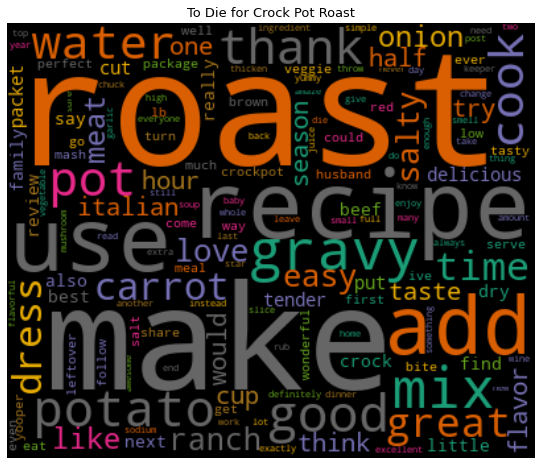

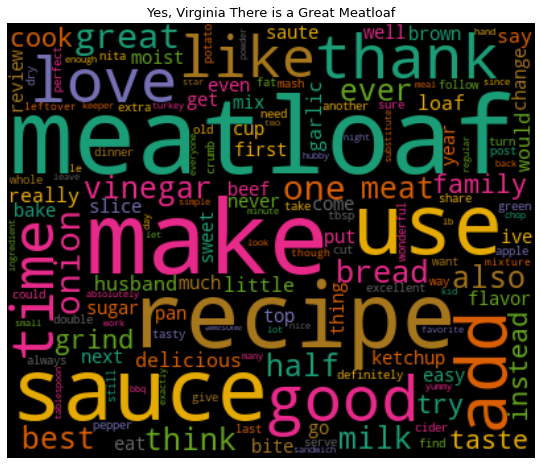

In [ ]:
from wordcloud import WordCloud
from textwrap import wrap

def generate_wordcloud(data,title):
    wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title('\n'.join(wrap(title,60)),fontsize=13)
    plt.show()

df_dtm=df_dtm.transpose()

for index,product in enumerate(df_dtm.columns):
    generate_wordcloud(df_dtm[product].sort_values(ascending=False),product)

In [ ]:
from textblob import TextBlob
fin_df['polarity']=fin_df['lemmatized'].apply(lambda x:TextBlob(x).sentiment.polarity)

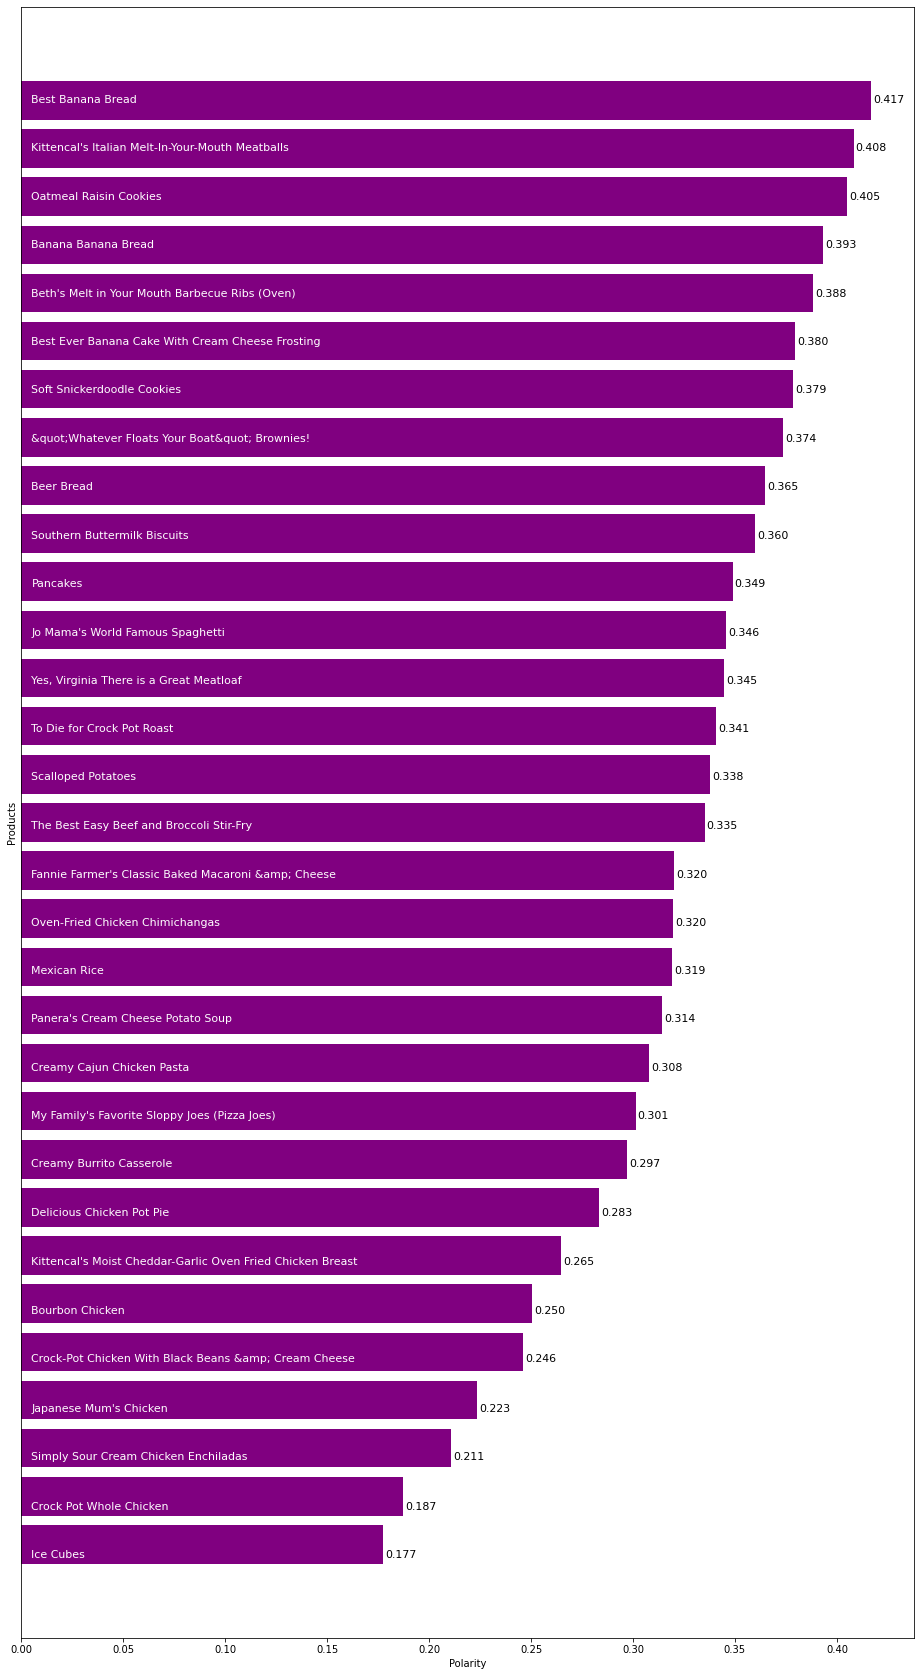

In [ ]:
product_polarity_sorted=pd.DataFrame(fin_df.groupby('Name')['polarity'].mean().sort_values(ascending=True))

plt.figure(figsize=(16,30))
plt.xlabel('Polarity')
plt.ylabel('Products')
polarity_graph=plt.barh(np.arange(len(product_polarity_sorted.index)),product_polarity_sorted['polarity'],color='purple',)

# Writing product names on bar
for bar,product in zip(polarity_graph,product_polarity_sorted.index):
    plt.text(0.005,bar.get_y()+bar.get_width(),'{}'.format(product),va='center',fontsize=11,color='white')

# Writing polarity values on graph
for bar,polarity in zip(polarity_graph,product_polarity_sorted['polarity']):
    plt.text(bar.get_width()+0.001,bar.get_y()+bar.get_width(),'%.3f'%polarity,va='center',fontsize=11,color='black')
plt.yticks([])
plt.show()

In [ ]:
from textblob import TextBlob
bloblist_desc = list()
df_review_str=fin_df['lemmatized'].astype(str)

In [ ]:
for row in df_review_str:
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    df_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['Review','sentiment','polarity'])

In [ ]:
df_polarity_desc.sample(20)

Review  sentiment  polarity
20284  cake real hit follow direction except use one ...   0.158333  0.444302
9221   cannot believe rat recipe find post back may l...   0.283333  0.383333
24229  kittencal remind episode emeril emeril taste d...   0.131981  0.426786
12698                      really easy really good thank   0.566667  0.716667
21210  certainly need leave yet another good review h...   0.044286  0.661984
32625  husband read ingredient think say celery salt ...   0.400000  0.560000
8753   love banana bread use ripe banana freeze follo...   0.310000  0.585000
6334   think say recipe already say roast tender grav...   0.750000  0.944444
18767  fantastic recipe try pizza joe variation get a...   0.225000  0.447222
20961  first time follow recipe exactly great second ...   0.116667  0.423810
8002   great tasty trouble fold tortilla though would...   0.200000  0.483333
12049  like need another review delicious love dish w...   0.352106  0.520696
33584  recipe much work decide instead call plumber c...   0.316667  0.233333
6587   okay controversy review salty salty decide mak...   0.426667  0.580000
23629  yummy big hit teenage boy cannot recall either...   0.050000  0.366667
34253  seem like lot hard work small return lot ice s...   0.011667  0.498333
4899   sugar seem mistake add late anyway ignore suga...   0.566667  0.866667
27849  cooky absolutely amaze easy make come great ma...   0.486667  0.816667
11461  oatmeal raisin cooky die turn perfect taste de...   0.833333  0.866667
19330  fantastic moist cake step want ruin freezer ge...   0.187143  0.717143

In [ ]:
def f(df_polarity_desc):
    if df_polarity_desc['sentiment'] > 0:
        val = "Positive Review"
    elif df_polarity_desc['sentiment'] == 0:
        val = "Neutral Review"
    else:
        val = "Negative Review"
    return val

In [ ]:
df_polarity_desc['Sentiment_Type'] =df_polarity_desc.apply(f,axis=1)

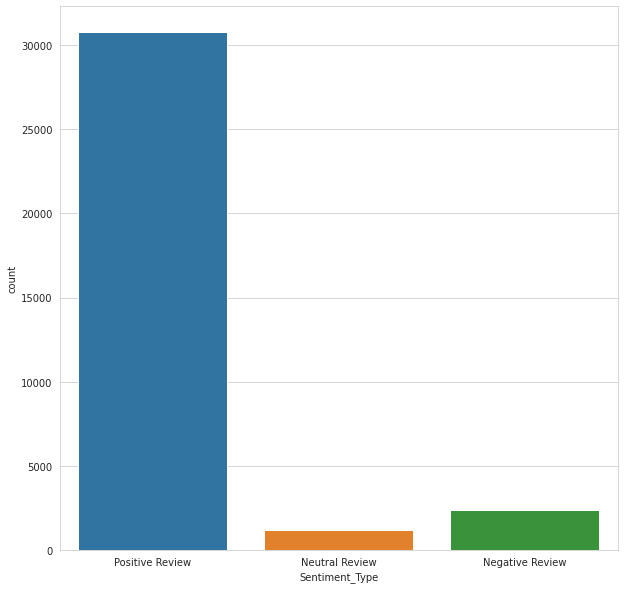

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=df_polarity_desc)

In [ ]:
positive_reviews=df_polarity_desc[df_polarity_desc['Sentiment_Type']=='Positive Review']
negative_reviews=df_polarity_desc[df_polarity_desc['Sentiment_Type']=='Negative Review']

In [ ]:
negative_reviews.head()

Review  ...   Sentiment_Type
115  like bread texture nice make would cut butter ...  ...  Negative Review
132  try recipe disappoint flavorful moist sour cre...  ...  Negative Review
149  indeed best banana bread real key recipe banan...  ...  Negative Review
309  terrific recipe usually add banana really like...  ...  Negative Review
334                                plain simple delish  ...  Negative Review

[5 rows x 4 columns]

In [ ]:
negative_reviews.shape[0]

2386

In [ ]:
positive_reviews.head()

Review  ...   Sentiment_Type
0  use one banana call use result bread yummy tho...  ...  Positive Review
1  search good banana bread recipe year finally f...  ...  Positive Review
2  try many many banana bread recipe year absolut...  ...  Positive Review
3                       yes really best banana bread  ...  Positive Review
4  try recipe grandchild love itnow ask time make...  ...  Positive Review

[5 rows x 4 columns]

In [ ]:
positive_reviews.shape[0]

30777

## NLP preprocessing

In [ ]:
#Exapnding contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","i've": "i have","i'd": "i would", "i'd've": "i would have","i'll": "i will",
                     "i'll've": "i will have","i'm": "i am","i've": "i have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

p['Review']=p['Review'].apply(lambda x:expand_contractions(x))

In [ ]:
#converting to lower case
p['Review']=p['Review'].apply(lambda x: x.lower())

In [ ]:

p['Review']=p['Review'].apply(lambda x: re.sub('\w*\d\w*','', x))

In [ ]:
#removing punctuations
p['Review']=p['Review'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [ ]:
#removing extra spaces
p['Review']=p['Review'].apply(lambda x: re.sub(' +',' ',x))

In [ ]:
#removing stopwords
stop = stopwords.words('english')

In [ ]:
p['Review'] = p['Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
#lemmatizing
lemmatizer = WordNetLemmatizer()

In [ ]:
p['Review'] = p['Review'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word, pos="n") for word in x.split()]))

In [ ]:
p['Review'] = p['Review'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word, pos="v") for word in x.split()]))

In [ ]:
p['Review'] = p['Review'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word, pos="a") for word in x.split()]))

In [ ]:
p.set_index("Name", inplace=True)

In [ ]:
p

Review
Name                                                                                                 
&quot;Whatever Floats Your Boat&quot; Brownies!     oh mythese good soooo chocola best brownie eve...
Banana Banana Bread                                 make muffin tin hand yummy get rave review kid...
Beer Bread                                          didnt turn welli could taste bakin agree lesa ...
Best Banana Bread                                   use one banana call search good banana bread t...
Best Ever Banana Cake With Cream Cheese Frosting    oh yes good banana cake okay say yummmmmmm out...
Beth's Melt in Your Mouth Barbecue Ribs (Oven)      would anyone bother go tony rom yummy recipe b...
Bourbon Chicken                                     first think aroma finishe good recipe tad hot ...
Creamy Burrito Casserole                            casserole great easy put good easy serve lipt ...
Creamy Cajun Chicken Pasta                          fantabulous dish sooooo good h scrumpdillyumpt...
Crock Pot Whole Chicken                             scrumptious spice mix give great colour use bo...
Crock-Pot Chicken With Black Beans &amp; Cream ...  wonderful best part prepare yesterday smell wo...
Delicious Chicken Pot Pie                           excellenti add mushroomsbell pepp chicken pot ...
Fannie Farmer's Classic Baked Macaroni &amp; Ch...  family make great recipe little bland good nic...
Ice Cubes                                           ha ha great recipe great recipe share others p...
Japanese Mum's Chicken                              really easy make u wow delicious use thigh won...
Jo Mama's World Famous Spaghetti                    far best spaghetti sauce hav taste good next t...
Kittencal's Italian Melt-In-Your-Mouth Meatballs    perfect go saucevery excellent use beef pork v...
Kittencal's Moist Cheddar-Garlic Oven Fried Chi...  try super bowl sunday along h wow love garlic ...
Mexican Rice                                        hand best rice dish simply best rich creamy ch...
My Family's Favorite Sloppy Joes (Pizza Joes)       delicious teenage son really enjoy fo wow grea...
Oatmeal Raisin Cookies                              chewy delicious right blend superb oatmeal coo...
Oven-Fried Chicken Chimichangas                     quick tasty find tort live new mexico definite...
Pancakes                                            really really good sweet pancake definately th...
Panera's Cream Cheese Potato Soup                   nice soup halfed recipe wonderful spicy creamy...
Scalloped Potatoes                                  easy make flavorful serve dear cc excallant re...
Simply Sour Cream Chicken Enchiladas                hii make recipe yesterday wa wonderful easy ma...
Soft Snickerdoodle Cookies                          best snickerdoodles make taste like cooky gran...
Southern Buttermilk Biscuits                        delicious light tender biscuit luscious melt m...
The Best Easy Beef and Broccoli Stir-Fry            excellentsimple recipe add v great eat small a...
To Die for Crock Pot Roast                          single guy right alley make last night huge hi...
Yes, Virginia There is a Great Meatloaf             husband want meatloaf like mother u nitarnmy h...

## Tfidf Matrix and Cosine Similarity

In [ ]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')

In [ ]:
tfidf_matrix = tf.fit_transform(p['Review'])  

In [ ]:
print((tfidf_matrix.shape))

(31, 3074)


In [ ]:
cosine_similarities_tf = cosine_similarity(tfidf_matrix,Y=None,dense_output=False)

In [ ]:
cnum = (cosine_similarities_tf.toarray())

In [ ]:
print(((cosine_similarities_tf[0][:1,:-19])))

  (0, 11)	0.013199770891534271
  (0, 10)	0.014607395410639752
  (0, 9)	0.011034309921288558
  (0, 8)	0.017725151137631824
  (0, 7)	0.03069710128758757
  (0, 6)	0.01487912118253766
  (0, 5)	0.02217777391880072
  (0, 4)	0.03750249786302456
  (0, 3)	0.023253870502445463
  (0, 2)	0.020585142233638595
  (0, 1)	0.013534230900117829
  (0, 0)	1.0000000000000007


In [ ]:
def get_recommendations(id):
    print("the product selected is {}".format(p.index[id]))
    a = cosine_similarities_tf.getcol(id)
    val = list(enumerate(a.data))
    #print(val)
    b= dict(val)
    #print(b)
    c = sorted(b.items(),key=lambda x:x[1],reverse=True)[1:4]
    k = 1
    print(c)
    for idx in c:
        print("The {} Recommendation is {}".format(k,p.index[idx[0]]))
        k += 1
get_recommendations(0)

the product selected is &quot;Whatever Floats Your Boat&quot; Brownies!
[(4, 0.03750249786302456), (15, 0.03490965645342486), (16, 0.03475819194504715)]
The 1 Recommendation is Best Ever Banana Cake With Cream Cheese Frosting
The 2 Recommendation is Jo Mama's World Famous Spaghetti
The 3 Recommendation is Kittencal's Italian Melt-In-Your-Mouth Meatballs


In [ ]:
p1 = p.copy()

## BERT embedding and cosine similarity

In [ ]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
sentence_embeddings = model.encode(p1['Review'])

In [ ]:
sentence_embeddings.shape

(31, 768)

In [ ]:
cosine_similarities = cosine_similarity(sentence_embeddings,Y=None,dense_output=False)

In [ ]:
cosine_similarities

array([[1.0000002 , 0.8257143 , 0.8270832 , 0.7961887 , 0.8170444 ,
        0.7749542 , 0.8235743 , 0.8409486 , 0.8258443 , 0.80504847,
        0.8811722 , 0.86131173, 0.8611088 , 0.7630193 , 0.8297375 ,
        0.8696495 , 0.80589175, 0.8133262 , 0.85530186, 0.81472623,
        0.91808844, 0.8040584 , 0.9141451 , 0.87668157, 0.88835233,
        0.8875083 , 0.9058387 , 0.88949084, 0.86674094, 0.8135386 ,
        0.7812749 ],
       [0.8257143 , 1.0000001 , 0.81658316, 0.9679607 , 0.9190941 ,
        0.7391553 , 0.70580536, 0.7492797 , 0.76226366, 0.7399922 ,
        0.79522973, 0.7572597 , 0.83051586, 0.69369215, 0.764073  ,
        0.7243671 , 0.7324156 , 0.77392435, 0.76132464, 0.76661277,
        0.7999815 , 0.7578265 , 0.8056356 , 0.78745985, 0.82658786,
        0.8006941 , 0.7998611 , 0.84655905, 0.7932848 , 0.6778076 ,
        0.6741501 ],
       [0.8270832 , 0.81658316, 0.9999999 , 0.80733126, 0.84142256,
        0.7444752 , 0.7558986 , 0.7535845 , 0.7432164 , 0.7397653 ,
      

In [ ]:
def get_recommendations(id):
    print("the product selected is {}".format(p.index[id]))
    a = cosine_similarities[id]
    val = list(enumerate(a))
    b= dict(val)
    c = sorted(b.items(),key=lambda x:x[1],reverse=True)[1:4]
    k = 1
    print(c)
    for idx in c:
        print("The {} Recommendation is {}".format(k,p.index[idx[0]]))
        k += 1
get_recommendations(0)

the product selected is &quot;Whatever Floats Your Boat&quot; Brownies!
[(20, 0.91808844), (22, 0.9141451), (26, 0.9058387)]
The 1 Recommendation is Oatmeal Raisin Cookies
The 2 Recommendation is Pancakes
The 3 Recommendation is Soft Snickerdoodle Cookies


## Tfidf matrix 

In [ ]:
tfv = TfidfVectorizer(lowercase=True,max_features=1000,stop_words= ENGLISH_STOP_WORDS)

In [ ]:
tfidf_matrix = tfv.fit_transform(p['Review'])

## kmeans 

In [ ]:
#BERT
temp = -1
maxm, j = 0, 0
for i in range(7, 15):
    km1 = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    model = km1.fit(sentence_embeddings)
    score = silhouette_score(sentence_embeddings, km1.labels_, metric='euclidean')
    if(score>temp):
        temp = score
        maxm = score
        j = i
    print(str(i),":",str(score))
print("Best:",str(j),"-",str(maxm))

7 : 0.10772221
8 : 0.118658006
9 : 0.09785345
10 : 0.12630387
11 : 0.11651849
12 : 0.11419562
13 : 0.13343921
14 : 0.096110284
Best: 13 - 0.13343921


In [ ]:
#tfidf
temp = -1
maxm, j = 0, 0
for i in range(7, 15):
    km1 = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    model = km1.fit(tfidf_matrix)
    score = silhouette_score(tfidf_matrix, km1.labels_, metric='euclidean')
    if(score>temp):
        temp = score
        maxm = score
        j = i
    print(str(i),":",str(score))
print("Best:",str(j),"-",str(maxm))

7 : 0.03261696690464973
8 : 0.036083985172841844
9 : 0.03733200627859108
10 : 0.03532279521132015
11 : 0.037404150461192366
12 : 0.03383994380160413
13 : 0.0403618981634895
14 : 0.04239256757028695
Best: 14 - 0.04239256757028695


In [ ]:
#BERT(db)
temp = 100
minm, j = 100, 0
for i in range(7, 15):
    km2 = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    model = km2.fit(sentence_embeddings)
    score = davies_bouldin_score(sentence_embeddings, km2.labels_)
    if(score<temp):
        temp = score
        minm = score
        j = i
    print(str(i),":",str(score))
print("Best:",str(j),"-",str(minm))

7 : 1.5506742998994092
8 : 1.3962762754183513
9 : 1.559126585282253
10 : 1.2649073091616767
11 : 1.2820352354523232
12 : 1.275094339046232
13 : 1.0724571186377707
14 : 1.0842556448827247
Best: 13 - 1.0724571186377707


In [ ]:
#tfidf(db)
temp = 100
minm, j = 100, 0
for i in range(7, 15):
    km2 = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    model = km2.fit(tfidf_matrix)
    score = davies_bouldin_score(tfidf_matrix.toarray(), km2.labels_)
    if(score<temp):
        temp = score
        minm = score
        j = i
    print(str(i),":",str(score))
print("Best:",str(j),"-",str(minm))

7 : 2.5410369461342532
8 : 2.297597657371666
9 : 2.046319863077777
10 : 1.915540631261205
11 : 1.7739979125499665
12 : 1.6581523219330474
13 : 1.6916526677853345
14 : 1.5136177506919268
Best: 14 - 1.5136177506919268


## Mini batch kmeans

In [ ]:
#BERT
temp = -1
maxm, j = 0, 0
for i in range(7, 15):
    cls = MiniBatchKMeans(n_clusters=i)
    cls.fit(sentence_embeddings)
    score = silhouette_score(sentence_embeddings, labels=cls.predict(sentence_embeddings), metric='euclidean')
    if(score>temp):
        temp = score
        maxm = score
        j = i
    print(str(i),":",str(score))
print("Best:",str(j),"-",str(maxm))

7 : 0.02750651
8 : 0.079162665
9 : 0.0729219
10 : 0.0230178
11 : 0.009434366
12 : 0.07023036
13 : 0.075690664
14 : 0.09167871
Best: 14 - 0.09167871


In [ ]:
#tfidf
temp = -1
maxm, j = 0, 0
for i in range(7, 15):
    cls = MiniBatchKMeans(n_clusters=i)
    cls.fit(tfidf_matrix)
    score = silhouette_score(tfidf_matrix, labels=cls.predict(tfidf_matrix), metric='euclidean')
    if(score>temp):
        temp = score
        maxm = score
        j = i
    print(str(i),":",str(score))
print("Best:",str(j),"-",str(maxm))

7 : 0.011497583054273666
8 : -0.01115563113828803
9 : 0.019861656278201165
10 : 0.005317681550206827
11 : -0.014475566536273264
12 : 0.0011755572714196628
13 : -0.003884391594570838
14 : 0.009093899552273053
Best: 9 - 0.019861656278201165


In [ ]:
#BERT(db)
temp = 100
minm, j = 100, 0
for i in range(7, 15):
    cls = MiniBatchKMeans(n_clusters=i)
    cls.fit(sentence_embeddings)
    score = davies_bouldin_score(sentence_embeddings, cls.labels_)
    if(score<temp):
        temp = score
        minm = score
        j = i
    print(str(i),":",str(score))
print("Best:",str(j),"-",str(minm))

7 : 1.5069553975730945
8 : 1.2454374799592292
9 : 1.2955261092579624
10 : 1.3465223899645065
11 : 1.3078786482668205
12 : 1.2403463062217301
13 : 1.0595248674217086
14 : 1.128095790328391
Best: 13 - 1.0595248674217086


In [ ]:
#tfidf(db)
temp = 100
minm, j = 100, 0
for i in range(7, 15):
    cls = MiniBatchKMeans(n_clusters=i)
    cls.fit(tfidf_matrix)
    score = davies_bouldin_score(tfidf_matrix.toarray(), cls.labels_)
    if(score<temp):
        temp = score
        minm = score
        j = i
    print(str(i),":",str(score))
print("Best:",str(j),"-",str(minm))

7 : 2.524426219555322
8 : 1.6561570053990822
9 : 1.8941621166490765
10 : 1.2882089282484883
11 : 1.4335752802314186
12 : 1.4167804843650382
13 : 1.5351966625954379
14 : 1.3336907994835427
Best: 10 - 1.2882089282484883


## Birch 

In [ ]:
#BERT
temp = -1
maxm, j = 0, 0
for i in range(7, 15):
    brc = Birch(n_clusters=i)
    brc.fit(sentence_embeddings)
    score = silhouette_score(sentence_embeddings, labels=brc.predict(sentence_embeddings), metric='euclidean')
    if(score>temp):
        temp = score
        maxm = score
        j = i
    print(str(i),":",str(score))
print("Best:",str(j),"-",str(maxm))

7 : 0.11769267
8 : 0.12098408
9 : 0.12678581
10 : 0.14060587
11 : 0.14092404
12 : 0.1379872
13 : 0.14027207
14 : 0.1357241
Best: 11 - 0.14092404


In [ ]:
#tfidf
temp = -1
maxm, j = 0, 0
for i in range(7, 15):
    brc = Birch(n_clusters=i)
    brc.fit(tfidf_matrix)
    score = silhouette_score(tfidf_matrix, labels=brc.predict(tfidf_matrix), metric='euclidean')
    if(score>temp):
        temp = score
        maxm = score
        j = i
    print(str(i),":",str(score))
print("Best:",str(j),"-",str(maxm))

7 : 0.0421184818387387
8 : 0.04432800745709193
9 : 0.04367479719675677
10 : 0.04468260472378544
11 : 0.04522793650054018
12 : 0.046022542329090366
13 : 0.045851149312233545
14 : 0.045931292904609844
Best: 12 - 0.046022542329090366


In [ ]:
#BERT(db)
temp = 100
minm, j = 100, 0
for i in range(7, 15):
    brc = Birch(n_clusters=i)
    brc.fit(sentence_embeddings)
    score = davies_bouldin_score(sentence_embeddings, brc.labels_)
    if(score<temp):
        temp = score
        minm = score
        j = i
    print(str(i),":",str(score))
print("Best:",str(j),"-",str(minm))

7 : 1.6603876487467666
8 : 1.4932433810541612
9 : 1.4310401219690605
10 : 1.353652504405216
11 : 1.2151457959622982
12 : 1.1368572226294043
13 : 1.0249471072398957
14 : 0.9629691107445263
Best: 14 - 0.9629691107445263


In [ ]:
#tfidf(db)
temp = 100
minm, j = 100, 0
for i in range(7, 15):
    brc = Birch(n_clusters=i)
    brc.fit(tfidf_matrix)
    score = davies_bouldin_score(tfidf_matrix.toarray(), brc.labels_)
    if(score<temp):
        temp = score
        minm = score
        j = i
    print(str(i),":",str(score))
print("Best:",str(j),"-",str(minm))

7 : 2.448335684585078
8 : 2.290809424467866
9 : 2.1091267522169863
10 : 2.0108294490379546
11 : 1.8625359404952038
12 : 1.7392262708021236
13 : 1.6477089014652992
14 : 1.4776269401901647
Best: 14 - 1.4776269401901647


## Hierarchical

In [ ]:
#BERT
temp = -1
maxm, j = 0, 0
for i in range(7, 15):
    hc = AgglomerativeClustering(n_clusters = i, affinity = 'euclidean', linkage = 'ward')
    model = hc.fit(sentence_embeddings)
    score = silhouette_score(sentence_embeddings, hc.labels_, metric='euclidean')
    if(score>temp):
        temp = score
        maxm = score
        j = i
    print(str(i),":",str(score))
print("Best:",str(j),"-",str(maxm))

7 : 0.11769267
8 : 0.12098408
9 : 0.12678581
10 : 0.14060587
11 : 0.14092404
12 : 0.1379872
13 : 0.14027207
14 : 0.1357241
Best: 11 - 0.14092404


In [ ]:
#tfidf
temp = -1
maxm, j = 0, 0
for i in range(7, 15):
    hc = AgglomerativeClustering(n_clusters = i, affinity = 'euclidean', linkage = 'ward')
    model = hc.fit(tfidf_matrix.toarray())
    score = silhouette_score(tfidf_matrix.toarray(), hc.labels_, metric='euclidean')
    if(score>temp):
        temp = score
        maxm = score
        j = i
    print(str(i),":",str(score))
print("Best:",str(j),"-",str(maxm))

7 : 0.04211848183873868
8 : 0.044328007457091916
9 : 0.043674797196756744
10 : 0.04468260472378542
11 : 0.04522793650054018
12 : 0.046022542329090366
13 : 0.04585114931223354
14 : 0.04593129290460987
Best: 12 - 0.046022542329090366


In [ ]:
#BERT(db)
temp = 100
minm, j = 100, 0
for i in range(7, 15):
    hc = AgglomerativeClustering(n_clusters = i, affinity = 'euclidean', linkage = 'ward')
    model = hc.fit(sentence_embeddings)
    score = davies_bouldin_score(sentence_embeddings, hc.labels_)
    if(score<temp):
        temp = score
        minm = score
        j = i
    print(str(i),":",str(score))
print("Best:",str(j),"-",str(minm))

7 : 1.6603876487467666
8 : 1.4932433810541612
9 : 1.4310401219690605
10 : 1.353652504405216
11 : 1.2151457959622982
12 : 1.1368572226294043
13 : 1.0249471072398957
14 : 0.9629691107445263
Best: 14 - 0.9629691107445263


In [ ]:
#tfidf(db)
temp = 100
minm, j = 100, 0
for i in range(7, 15):
    hc = AgglomerativeClustering(n_clusters = i, affinity = 'euclidean', linkage = 'ward')
    model = hc.fit(tfidf_matrix.toarray())
    score = davies_bouldin_score(tfidf_matrix.toarray(), hc.labels_)
    if(score<temp):
        temp = score
        minm = score
        j = i
    print(str(i),":",str(score))
print("Best:",str(j),"-",str(minm))

7 : 2.448335684585078
8 : 2.290809424467866
9 : 2.109126752216986
10 : 2.010829449037955
11 : 1.8625359404952035
12 : 1.7392262708021233
13 : 1.6477089014652992
14 : 1.4776269401901647
Best: 14 - 1.4776269401901647


## Clustering

In [ ]:
p2 = p.copy()
p3 = p.copy()
p4 = p.copy()
p5 = p.copy()

In [ ]:
p2.reset_index(inplace = True)
p3.reset_index(inplace = True)
p4.reset_index(inplace = True)
p5.reset_index(inplace = True)

In [ ]:
km = KMeans(n_clusters=13, init='k-means++', n_init=10, max_iter=100, random_state=42)
model1 = km.fit(sentence_embeddings)
a = model1.predict(sentence_embeddings)
p2['Prediction'] = a

In [ ]:
brc = Birch(n_clusters=13)
model2 = brc.fit(sentence_embeddings)
a = model2.predict(sentence_embeddings)
p3['Prediction'] = a

In [ ]:
cls = MiniBatchKMeans(n_clusters=13)
model3 = cls.fit(sentence_embeddings)
a = model3.predict(sentence_embeddings)
p4['Prediction'] = a

In [ ]:
hc = AgglomerativeClustering(n_clusters = 13, affinity = 'euclidean', linkage = 'ward')
a = hc.fit_predict(sentence_embeddings)
p5['Prediction'] = a

## Model Outcome

In [ ]:
text = ["I prefer chicken", "sweet is my favourite", "love rice"]

In [ ]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
#K-Means
p2

Name  ... Prediction
0     &quot;Whatever Floats Your Boat&quot; Brownies!  ...          7
1                                 Banana Banana Bread  ...          2
2                                          Beer Bread  ...         12
3                                   Best Banana Bread  ...          2
4    Best Ever Banana Cake With Cream Cheese Frosting  ...          2
5      Beth's Melt in Your Mouth Barbecue Ribs (Oven)  ...          3
6                                     Bourbon Chicken  ...          1
7                            Creamy Burrito Casserole  ...          5
8                          Creamy Cajun Chicken Pasta  ...          1
9                             Crock Pot Whole Chicken  ...          1
10  Crock-Pot Chicken With Black Beans &amp; Cream...  ...          1
11                          Delicious Chicken Pot Pie  ...          1
12  Fannie Farmer's Classic Baked Macaroni &amp; C...  ...         10
13                                          Ice Cubes  ...         11
14                             Japanese Mum's Chicken  ...          0
15                   Jo Mama's World Famous Spaghetti  ...          0
16   Kittencal's Italian Melt-In-Your-Mouth Meatballs  ...          5
17  Kittencal's Moist Cheddar-Garlic Oven Fried Ch...  ...          1
18                                       Mexican Rice  ...          6
19      My Family's Favorite Sloppy Joes (Pizza Joes)  ...          8
20                             Oatmeal Raisin Cookies  ...          7
21                    Oven-Fried Chicken Chimichangas  ...          3
22                                           Pancakes  ...          7
23                  Panera's Cream Cheese Potato Soup  ...          4
24                                 Scalloped Potatoes  ...          4
25               Simply Sour Cream Chicken Enchiladas  ...          1
26                         Soft Snickerdoodle Cookies  ...          0
27                       Southern Buttermilk Biscuits  ...         10
28           The Best Easy Beef and Broccoli Stir-Fry  ...          0
29                         To Die for Crock Pot Roast  ...          9
30            Yes, Virginia There is a Great Meatloaf  ...          5

[31 rows x 3 columns]

In [ ]:
text = model.encode(text)
out1 = model1.predict(text)
out1

array([1, 7, 0], dtype=int32)

In [ ]:
#Birch
p3

Name  ... Prediction
0     &quot;Whatever Floats Your Boat&quot; Brownies!  ...          6
1                                 Banana Banana Bread  ...          5
2                                          Beer Bread  ...          0
3                                   Best Banana Bread  ...          5
4    Best Ever Banana Cake With Cream Cheese Frosting  ...          5
5      Beth's Melt in Your Mouth Barbecue Ribs (Oven)  ...          3
6                                     Bourbon Chicken  ...          1
7                            Creamy Burrito Casserole  ...          8
8                          Creamy Cajun Chicken Pasta  ...          1
9                             Crock Pot Whole Chicken  ...          1
10  Crock-Pot Chicken With Black Beans &amp; Cream...  ...          1
11                          Delicious Chicken Pot Pie  ...          1
12  Fannie Farmer's Classic Baked Macaroni &amp; C...  ...          0
13                                          Ice Cubes  ...          7
14                             Japanese Mum's Chicken  ...          2
15                   Jo Mama's World Famous Spaghetti  ...         12
16   Kittencal's Italian Melt-In-Your-Mouth Meatballs  ...          8
17  Kittencal's Moist Cheddar-Garlic Oven Fried Ch...  ...          1
18                                       Mexican Rice  ...         11
19      My Family's Favorite Sloppy Joes (Pizza Joes)  ...         10
20                             Oatmeal Raisin Cookies  ...          6
21                    Oven-Fried Chicken Chimichangas  ...          3
22                                           Pancakes  ...          6
23                  Panera's Cream Cheese Potato Soup  ...          4
24                                 Scalloped Potatoes  ...          4
25               Simply Sour Cream Chicken Enchiladas  ...          1
26                         Soft Snickerdoodle Cookies  ...          2
27                       Southern Buttermilk Biscuits  ...          0
28           The Best Easy Beef and Broccoli Stir-Fry  ...          2
29                         To Die for Crock Pot Roast  ...          9
30            Yes, Virginia There is a Great Meatloaf  ...          8

[31 rows x 3 columns]

In [ ]:
out2 = model2.predict(text)
out2

array([ 1,  6, 11])

In [ ]:
#MinibatchKmeans
p4

Name  ... Prediction
0     &quot;Whatever Floats Your Boat&quot; Brownies!  ...          9
1                                 Banana Banana Bread  ...          2
2                                          Beer Bread  ...         11
3                                   Best Banana Bread  ...          2
4    Best Ever Banana Cake With Cream Cheese Frosting  ...          2
5      Beth's Melt in Your Mouth Barbecue Ribs (Oven)  ...          7
6                                     Bourbon Chicken  ...          3
7                            Creamy Burrito Casserole  ...         10
8                          Creamy Cajun Chicken Pasta  ...          3
9                             Crock Pot Whole Chicken  ...          3
10  Crock-Pot Chicken With Black Beans &amp; Cream...  ...          3
11                          Delicious Chicken Pot Pie  ...          3
12  Fannie Farmer's Classic Baked Macaroni &amp; C...  ...          6
13                                          Ice Cubes  ...          6
14                             Japanese Mum's Chicken  ...          5
15                   Jo Mama's World Famous Spaghetti  ...          3
16   Kittencal's Italian Melt-In-Your-Mouth Meatballs  ...         10
17  Kittencal's Moist Cheddar-Garlic Oven Fried Ch...  ...          3
18                                       Mexican Rice  ...          4
19      My Family's Favorite Sloppy Joes (Pizza Joes)  ...         12
20                             Oatmeal Raisin Cookies  ...          9
21                    Oven-Fried Chicken Chimichangas  ...          7
22                                           Pancakes  ...          1
23                  Panera's Cream Cheese Potato Soup  ...          3
24                                 Scalloped Potatoes  ...          6
25               Simply Sour Cream Chicken Enchiladas  ...          3
26                         Soft Snickerdoodle Cookies  ...          0
27                       Southern Buttermilk Biscuits  ...          0
28           The Best Easy Beef and Broccoli Stir-Fry  ...          6
29                         To Die for Crock Pot Roast  ...          8
30            Yes, Virginia There is a Great Meatloaf  ...         10

[31 rows x 3 columns]

In [ ]:
out3 = model3.predict(text)
out3

array([3, 9, 4], dtype=int32)

In [ ]:
#Agglomerative
p5

Name  ... Prediction
0     &quot;Whatever Floats Your Boat&quot; Brownies!  ...          6
1                                 Banana Banana Bread  ...          5
2                                          Beer Bread  ...          0
3                                   Best Banana Bread  ...          5
4    Best Ever Banana Cake With Cream Cheese Frosting  ...          5
5      Beth's Melt in Your Mouth Barbecue Ribs (Oven)  ...          3
6                                     Bourbon Chicken  ...          1
7                            Creamy Burrito Casserole  ...          8
8                          Creamy Cajun Chicken Pasta  ...          1
9                             Crock Pot Whole Chicken  ...          1
10  Crock-Pot Chicken With Black Beans &amp; Cream...  ...          1
11                          Delicious Chicken Pot Pie  ...          1
12  Fannie Farmer's Classic Baked Macaroni &amp; C...  ...          0
13                                          Ice Cubes  ...          7
14                             Japanese Mum's Chicken  ...          2
15                   Jo Mama's World Famous Spaghetti  ...         12
16   Kittencal's Italian Melt-In-Your-Mouth Meatballs  ...          8
17  Kittencal's Moist Cheddar-Garlic Oven Fried Ch...  ...          1
18                                       Mexican Rice  ...         11
19      My Family's Favorite Sloppy Joes (Pizza Joes)  ...         10
20                             Oatmeal Raisin Cookies  ...          6
21                    Oven-Fried Chicken Chimichangas  ...          3
22                                           Pancakes  ...          6
23                  Panera's Cream Cheese Potato Soup  ...          4
24                                 Scalloped Potatoes  ...          4
25               Simply Sour Cream Chicken Enchiladas  ...          1
26                         Soft Snickerdoodle Cookies  ...          2
27                       Southern Buttermilk Biscuits  ...          0
28           The Best Easy Beef and Broccoli Stir-Fry  ...          2
29                         To Die for Crock Pot Roast  ...          9
30            Yes, Virginia There is a Great Meatloaf  ...          8

[31 rows x 3 columns]

## Polarity based

In [ ]:
p6 = p.copy()
p6.reset_index(inplace=True)

In [ ]:
p6['polarity']=p6['Review'].apply(lambda x:TextBlob(x).sentiment.polarity)

In [ ]:
product_polarity_sorted=pd.DataFrame(p6.groupby('Name')['polarity'].mean().sort_values(ascending=True))

In [ ]:
product_polarity_sorted.sort_values(by='polarity',ascending=False).reset_index()

Name  polarity
0     &quot;Whatever Floats Your Boat&quot; Brownies!  0.818519
1    Kittencal's Italian Melt-In-Your-Mouth Meatballs  0.716667
2                                   Best Banana Bread  0.625758
3             Yes, Virginia There is a Great Meatloaf  0.625000
4                              Oatmeal Raisin Cookies  0.591518
5    Best Ever Banana Cake With Cream Cheese Frosting  0.590000
6            The Best Easy Beef and Broccoli Stir-Fry  0.570370
7                          Soft Snickerdoodle Cookies  0.546875
8                    Jo Mama's World Famous Spaghetti  0.520000
9                          To Die for Crock Pot Roast  0.500952
10                       Southern Buttermilk Biscuits  0.495238
11                                       Mexican Rice  0.480882
12                                          Ice Cubes  0.461905
13                                           Pancakes  0.460256
14                  Panera's Cream Cheese Potato Soup  0.450893
15                                Banana Banana Bread  0.438300
16                           Creamy Burrito Casserole  0.433333
17                    Oven-Fried Chicken Chimichangas  0.412005
18                                         Beer Bread  0.369048
19                                 Scalloped Potatoes  0.342083
20                         Creamy Cajun Chicken Pasta  0.338889
21                                    Bourbon Chicken  0.330769
22                             Japanese Mum's Chicken  0.311111
23                          Delicious Chicken Pot Pie  0.309524
24               Simply Sour Cream Chicken Enchiladas  0.260606
25  Crock-Pot Chicken With Black Beans &amp; Cream...  0.257843
26  Fannie Farmer's Classic Baked Macaroni &amp; C...  0.256683
27      My Family's Favorite Sloppy Joes (Pizza Joes)  0.198148
28                            Crock Pot Whole Chicken  0.162222
29     Beth's Melt in Your Mouth Barbecue Ribs (Oven)  0.155000
30  Kittencal's Moist Cheddar-Garlic Oven Fried Ch...  0.132176